In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/01 15:05:16 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/11/01 15:05:18 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_229/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Pandas

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['min', 'mean', 'sum', 'max', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
max_week = 43

In [6]:
# # df_PD = pd.read_pickle('df_churn_all.pkl')

# # df_scoring = spark.read.table('b2b_stg.df_churn_all_agg_131025')
# df_scoring = spark.read.table('b2b_stg.df_churn_all_agg_201025')

# print('num_rows:', df_scoring.count())
# df_scoring.printSchema()

In [7]:
# df_PD = df_scoring.toPandas()

# df_PD = df_PD.sort_values(['subscriber_sk', 'week_of_year'])

# print(df_PD.shape)
# df_PD.head(2)

# # (15 225 495, 28)
# # (20 081 473, 28)

In [8]:
df_scoring = spark.read.table('b2b_stg.df_churn_all_agg_271025')

print('num_rows:', df_scoring.count())
# num_rows: 19 873 521

num_rows: 19873521


In [9]:
df_PD = df_scoring.toPandas()

df_PD = df_PD.sort_values(['subscriber_sk', 'week_of_year'])

print(df_PD.shape)
df_PD.head(2)

(19873521, 28)


,subscriber_sk,week_of_year,subs_market_cd,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,reason_1,...,good_days_sum,price_plan_type_max,repr2q2025_max,churn_flg,voice_min_1_H_countNA,voice_min_2_H_countNA,voice_min_1_R_countNA,voice_min_2_R_countNA,gprs_mb_3_H_countNA,gprs_mb_3_R_countNA
8986549,254,40,VIP,17.261905,9.440476,0.000000,0.000000,198.967145,0.0,None,...,3.0,Bundle,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
12443204,254,41,VIP,1.500000,1.394444,1.744444,0.359259,939.085558,0.0,None,...,1.0,Bundle,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# df_PD = pd.read_pickle('df_churn_2209_1810.pkl').drop(['reason_1', 'reason_2', 'reason_3', 
#                                                          'voice_min_1_H_countNA', 'voice_min_2_H_countNA',
#                                                          'voice_min_1_R_countNA', 'voice_min_2_R_countNA', 
#                                                         'gprs_mb_3_H_countNA', 'gprs_mb_3_R_countNA'], axis = 1)

df_PD = df_PD.drop(['reason_1', 'reason_2', 'reason_3', 
                    'voice_min_1_H_countNA', 'voice_min_2_H_countNA',
                    'voice_min_1_R_countNA', 'voice_min_2_R_countNA', 
                    'gprs_mb_3_H_countNA', 'gprs_mb_3_R_countNA'], axis = 1)

print(df_PD.shape)
df_PD.head(2)

# (20081473, 19)

(19873521, 19)


,subscriber_sk,week_of_year,subs_market_cd,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,dialog_time_sum,req_qnt_sum,active_days_sum,bad_days_sum,accept_days_sum,good_days_sum,price_plan_type_max,repr2q2025_max,churn_flg
8986549,254,40,VIP,17.261905,9.440476,0.000000,0.000000,198.967145,0.0,0.0,0.0,0.0,7.0,3.0,1.0,3.0,Bundle,1.0,NaN
12443204,254,41,VIP,1.500000,1.394444,1.744444,0.359259,939.085558,0.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,Bundle,1.0,NaN


In [11]:
df_PD['churn_flg'] = df_PD['churn_flg'].fillna(0)
df_PD['churn_flg'].value_counts()

0.0    19855344
1.0       18177
Name: churn_flg, dtype: int64

In [12]:
# *********************************** Traffic triggers: *********************************************
list_var_dec_30 = ['voice_min_1_H_avg', 'voice_min_2_H_avg', 'voice_min_1_R_avg', 'voice_min_2_R_avg',
                   'gprs_mb_3_H_avg', 'gprs_mb_3_R_avg']

df_PD = df_PD.sort_values(['subscriber_sk', 'week_of_year'])
df_PD = df_PD.reset_index(drop = True)
print(df_PD.shape)

for i in list_var_dec_30:
    df_PD[i + '_next'] = df_PD.groupby(['subscriber_sk'])[i].shift(-1)
    df_PD[i + '_delta_part'] = (df_PD[i + '_next'] - df_PD[i]) / df_PD[i]
    df_PD[i + '_gr30'] = df_PD[i + '_delta_part'].apply(lambda x: 1 if x <= -0.3 else 0)
    df_PD[i + '_gr30' + '_sum'] = df_PD.groupby(['subscriber_sk'])[i + '_gr30'].transform('sum')

print(df_PD.shape)
df_PD.head()

(19873521, 19)
(19873521, 43)


,subscriber_sk,week_of_year,subs_market_cd,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,...,voice_min_2_R_avg_gr30,voice_min_2_R_avg_gr30_sum,gprs_mb_3_H_avg_next,gprs_mb_3_H_avg_delta_part,gprs_mb_3_H_avg_gr30,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_R_avg_next,gprs_mb_3_R_avg_delta_part,gprs_mb_3_R_avg_gr30,gprs_mb_3_R_avg_gr30_sum
0,254,40,VIP,17.261905,9.440476,0.000000,0.000000,198.967145,0.0,0.0,...,0,1,939.085558,3.719802,0,1,0.0,NaN,0,0
1,254,41,VIP,1.500000,1.394444,1.744444,0.359259,939.085558,0.0,0.0,...,1,1,70.567147,-0.924855,1,1,0.0,NaN,0,0
2,254,42,VIP,1.083333,3.000000,0.000000,0.000000,70.567147,0.0,0.0,...,0,1,260.817778,2.696023,0,1,0.0,NaN,0,0
3,254,43,VIP,0.620370,2.101852,2.138889,1.750000,260.817778,0.0,0.0,...,0,1,NaN,NaN,0,1,NaN,NaN,0,0
4,265,40,VIP,0.480952,0.657143,0.000000,0.000000,540.145718,0.0,0.0,...,0,0,339.567145,-0.371342,1,2,0.0,NaN,0,0


In [13]:
df_PD.drop(['voice_min_1_H_avg_next', 'voice_min_1_H_avg_delta_part', 'voice_min_1_H_avg_gr30', 
               'voice_min_2_H_avg_next', 'voice_min_2_H_avg_delta_part', 'voice_min_2_H_avg_gr30',
               'voice_min_1_R_avg_next', 'voice_min_1_R_avg_delta_part', 'voice_min_1_R_avg_gr30', 
               'voice_min_2_R_avg_next', 'voice_min_2_R_avg_delta_part', 'voice_min_2_R_avg_gr30', 
               'gprs_mb_3_H_avg_next', 'gprs_mb_3_H_avg_delta_part', 'gprs_mb_3_H_avg_gr30', 
               'gprs_mb_3_R_avg_next', 'gprs_mb_3_R_avg_delta_part', 'gprs_mb_3_R_avg_gr30'], axis = 1, inplace = True)

##### Dummies

In [14]:
categ_columns = ['price_plan_type_max']

for column in categ_columns: 
    
    dummies = pd.get_dummies(df_PD[column], prefix = column)
    df_PD[dummies.columns] = dummies
    df_PD.drop([column], inplace = True, axis = 1)

##### TF-IDF Vectorization

In [15]:
import sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

print('df_PD.shape:', df_PD.shape)

# ********************** List of features: ***************************
all_features = ['subs_market_cd']

for i in range(len(all_features)):
    
    feature = all_features[i]
    texts = df_PD[feature].fillna('-1')


    # ******************* save model transformer 07.10.25: ********************
    with open('TF_IDF_vectorizer_churn_3_' + feature + '.pkl', 'rb') as fid:
        vectorizer = pickle.load(fid)

    tfidf_matrix = vectorizer.transform(texts)
    
    # Convert to DataFrame:
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())

    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    df_PD.drop(feature, axis = 1, inplace = True)
    df_PD = pd.concat([df_PD, tfidf_df], axis = 1)

print(df_PD.shape)
df_PD.head(3)

df_PD.shape: (19873521, 28)
(19873521, 32)


,subscriber_sk,week_of_year,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,dialog_time_sum,...,gprs_mb_3_R_avg_gr30_sum,price_plan_type_max_Bundle,price_plan_type_max_Data,price_plan_type_max_Line,price_plan_type_max_Other,subs_market_cd_ekt,subs_market_cd_kzn,subs_market_cd_spb,subs_market_cd_ufa,subs_market_cd_vip
0,254,40,17.261905,9.440476,0.000000,0.000000,198.967145,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
1,254,41,1.500000,1.394444,1.744444,0.359259,939.085558,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
2,254,42,1.083333,3.000000,0.000000,0.000000,70.567147,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0


In [17]:
41 - 37

4

#### Features

In [18]:
# 26
model_features = ['gprs_mb_3_H_avg_gr30_sum',
 'gprs_mb_3_H_avg',
 'voice_min_1_H_avg_gr30_sum',
 'voice_min_1_R_avg',
 'voice_min_2_H_avg_gr30_sum',
 'price_plan_type_max_Other',
 'active_days_sum',
 'price_plan_type_max_Bundle',
 'voice_min_2_H_avg',
 'voice_min_2_R_avg_gr30_sum',
 'voice_min_1_H_avg',
 'good_days_sum',
 'accept_days_sum',
 'bad_days_sum',
 'voice_min_1_R_avg_gr30_sum',
 'repr2q2025_max',
 'subs_market_cd_vip',
 'voice_min_2_R_avg',
 'price_plan_type_max_Line',
 'subs_market_cd_ekt',
 'gprs_mb_3_R_avg_gr30_sum',
 'subs_market_cd_kzn',
 'price_plan_type_max_Data',
 'subs_market_cd_ufa',
 'subs_market_cd_spb',
 'calls_sum'
]

print(len(model_features))

26


In [19]:
df_PD['week_of_year'].value_counts()

40    5063520
41    4978650
42    4974306
43    4857045
Name: week_of_year, dtype: int64

In [20]:
# max_week = df_PD['week_of_year'].max()
# max_week

In [21]:
# X = df_PD[df_PD['target'].isna() == False][model_features]
# y = df_PD[df_PD['target'].isna() == False]['target']

# df_week_max = df_PD[df_PD['week_of_year'] == 42]
df_week_max = df_PD[df_PD['week_of_year'] == max_week]
print(df_week_max.shape)

# (4855421, 32)

(4857045, 32)


In [22]:
# *************** save model 15.10.25: *****************

# with open('model_churn_not_balanced.pkl', 'wb') as fid:
#         pickle.dump(clf_lgb, fid)

# ********************** read: ***********************

with open('model_churn_not_balanced.pkl', 'rb') as fid:
    clf_lgb = pickle.load(fid)

In [29]:
df_week_max = df_PD[df_PD['week_of_year'] == max_week]

print(df_week_max.shape)
df_week_max.head()
# (4 855 421, 32)

(4857045, 32)


,subscriber_sk,week_of_year,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,dialog_time_sum,...,gprs_mb_3_R_avg_gr30_sum,price_plan_type_max_Bundle,price_plan_type_max_Data,price_plan_type_max_Line,price_plan_type_max_Other,subs_market_cd_ekt,subs_market_cd_kzn,subs_market_cd_spb,subs_market_cd_ufa,subs_market_cd_vip
3,254,43,0.620370,2.101852,2.138889,1.75,260.817778,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
7,265,43,0.480952,0.450000,0.000000,0.00,400.900003,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
11,300,43,5.950000,12.059524,0.000000,0.00,144.851430,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
16,450,43,3.780952,8.300000,0.000000,0.00,132.581433,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0
20,464,43,12.453704,13.361111,3.337037,1.15,2287.651113,0.0,0.0,0.0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,1.0


In [30]:
df_week_max = df_week_max.reset_index(drop = True)

#### Week

In [31]:
df_week_max['repr2q2025_max'].value_counts()

0.0    3598561
1.0     502149
Name: repr2q2025_max, dtype: int64

In [32]:
df_week_max[model_features].isna().sum()

gprs_mb_3_H_avg_gr30_sum           0
gprs_mb_3_H_avg                    0
voice_min_1_H_avg_gr30_sum         0
voice_min_1_R_avg                  0
voice_min_2_H_avg_gr30_sum         0
price_plan_type_max_Other          0
active_days_sum                    0
price_plan_type_max_Bundle         0
voice_min_2_H_avg                  0
voice_min_2_R_avg_gr30_sum         0
voice_min_1_H_avg                  0
good_days_sum                      0
accept_days_sum                    0
bad_days_sum                       0
voice_min_1_R_avg_gr30_sum         0
repr2q2025_max                756335
subs_market_cd_vip                 0
voice_min_2_R_avg                  0
price_plan_type_max_Line           0
subs_market_cd_ekt                 0
gprs_mb_3_R_avg_gr30_sum           0
subs_market_cd_kzn                 0
price_plan_type_max_Data           0
subs_market_cd_ufa                 0
subs_market_cd_spb                 0
calls_sum                          0
dtype: int64

In [33]:
df_week_max['repr2q2025_max'] = df_week_max['repr2q2025_max'].fillna(0)

(4857045, 33)
(4857045, 1)


array([[<Axes: title={'center': 'score_ML'}>]], dtype=object)

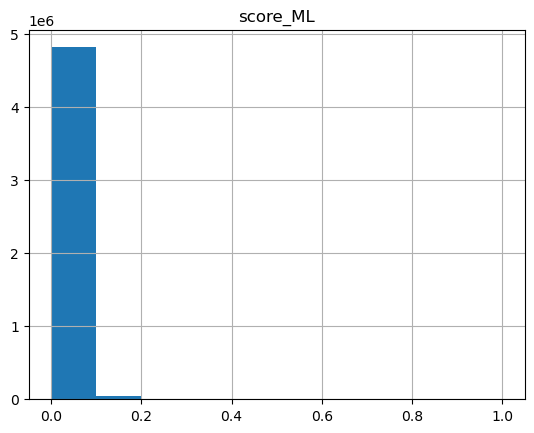

In [34]:
# y_pred = clf_lgb.predict_proba(X[model_features])[:,1]
y_pred = clf_lgb.predict_proba(df_week_max[model_features])[:,1]

y_pred_pd = pd.DataFrame(y_pred).rename(columns = {0: 'score_ML'})

df_week_max['score_ML'] = y_pred_pd

print(df_week_max.shape)

print(y_pred_pd.shape)
y_pred_pd.hist()

array([[<Axes: title={'center': 'score_ML'}>]], dtype=object)

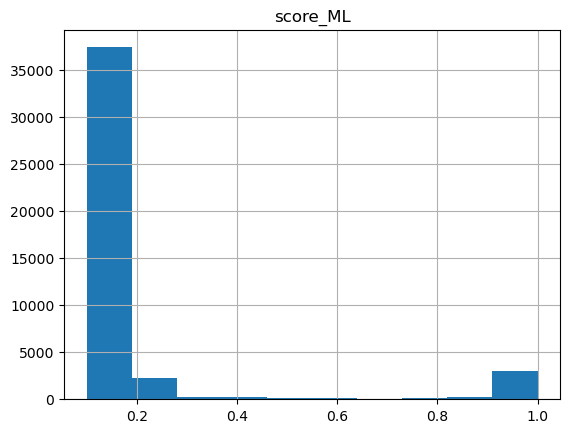

In [35]:
y_pred_pd[y_pred_pd['score_ML'] > 0.1].hist()

array([[<Axes: title={'center': 'score_ML'}>]], dtype=object)

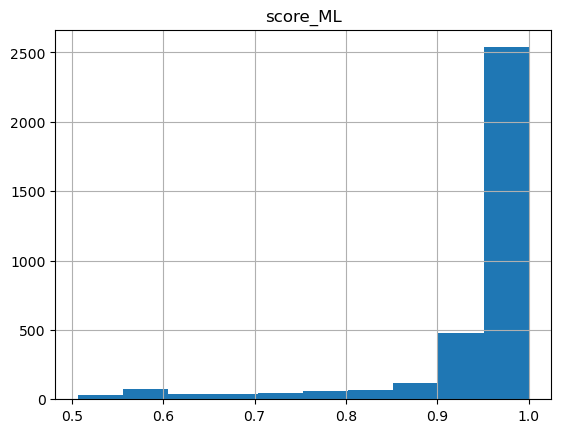

In [36]:
y_pred_pd[y_pred_pd['score_ML'] > 0.5].hist()

In [37]:
y_pred_pd[y_pred_pd['score_ML'] > 0.98].shape

(1623, 1)

In [38]:
y_pred_pd[y_pred_pd['score_ML'] > 0.975].shape

(1923, 1)

In [39]:
y_pred_pd['score_ML'].value_counts()

0.001291    443471
0.000051    226213
0.001409    110813
0.004390     70291
0.000058     57050
             ...  
0.006256         1
0.000052         1
0.001407         1
0.002082         1
0.030468         1
Name: score_ML, Length: 384485, dtype: int64

In [40]:
y_pred_pd[y_pred_pd['score_ML'] == 1].shape

(253, 1)

In [41]:
# df_tmp = y_pred_pd[y_pred_pd['score_ML'] != 1.0]['score_ML']
# df_tmp.sort_values(ascending = False).head(50)

In [42]:
print(df_week_max.shape)

df_week_max = df_week_max.reset_index(drop = True)
df_week_max.head(3)

(4857045, 33)


,subscriber_sk,week_of_year,voice_min_1_H_avg,voice_min_2_H_avg,voice_min_1_R_avg,voice_min_2_R_avg,gprs_mb_3_H_avg,gprs_mb_3_R_avg,calls_sum,dialog_time_sum,...,price_plan_type_max_Bundle,price_plan_type_max_Data,price_plan_type_max_Line,price_plan_type_max_Other,subs_market_cd_ekt,subs_market_cd_kzn,subs_market_cd_spb,subs_market_cd_ufa,subs_market_cd_vip,score_ML
0,254,43,0.620370,2.101852,2.138889,1.75,260.817778,0.0,0.0,0.0,...,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.037500
1,265,43,0.480952,0.450000,0.000000,0.00,400.900003,0.0,0.0,0.0,...,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.031703
2,300,43,5.950000,12.059524,0.000000,0.00,144.851430,0.0,0.0,0.0,...,1,0,0,0,0.0,0.0,0.0,0.0,1.0,0.020220


In [43]:
# df_week_max[df_week_max['subscriber_sk'] == 233755016].T
df_week_max['score_ML'].isna().sum()

0

In [47]:
# shape_cols = list(summary_df.columns)
# len(shape_cols)

In [48]:
X_out = df_week_max[['subscriber_sk', 'week_of_year'] + model_features + ['score_ML']]
# X_out = df_week_max[['subscriber_sk', 'week_of_year'] + shape_cols + ['score_ML']]

X_out = X_out.reset_index(drop = True)

print(X_out.shape)
X_out.head(3)

(4857045, 29)


,subscriber_sk,week_of_year,gprs_mb_3_H_avg_gr30_sum,gprs_mb_3_H_avg,voice_min_1_H_avg_gr30_sum,voice_min_1_R_avg,voice_min_2_H_avg_gr30_sum,price_plan_type_max_Other,active_days_sum,price_plan_type_max_Bundle,...,voice_min_2_R_avg,price_plan_type_max_Line,subs_market_cd_ekt,gprs_mb_3_R_avg_gr30_sum,subs_market_cd_kzn,price_plan_type_max_Data,subs_market_cd_ufa,subs_market_cd_spb,calls_sum,score_ML
0,254,43,1,260.817778,2,2.138889,1,0,7.0,1,...,1.75,0,0.0,0,0.0,0,0.0,0.0,0.0,0.037500
1,265,43,2,400.900003,2,0.000000,1,0,6.0,1,...,0.00,0,0.0,0,0.0,0,0.0,0.0,0.0,0.031703
2,300,43,1,144.851430,1,0.000000,1,0,6.0,1,...,0.00,0,0.0,0,0.0,0,0.0,0.0,0.0,0.020220


In [49]:
X_out['week_of_year'].value_counts()

43    4857045
Name: week_of_year, dtype: int64

In [50]:
# X_out.info()

In [51]:
# ************************************************* Spark download: ******************************************************************

In [52]:
X_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857045 entries, 0 to 4857044
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   subscriber_sk               int64  
 1   week_of_year                int32  
 2   gprs_mb_3_H_avg_gr30_sum    int64  
 3   gprs_mb_3_H_avg             float64
 4   voice_min_1_H_avg_gr30_sum  int64  
 5   voice_min_1_R_avg           float64
 6   voice_min_2_H_avg_gr30_sum  int64  
 7   price_plan_type_max_Other   uint8  
 8   active_days_sum             float64
 9   price_plan_type_max_Bundle  uint8  
 10  voice_min_2_H_avg           float64
 11  voice_min_2_R_avg_gr30_sum  int64  
 12  voice_min_1_H_avg           float64
 13  good_days_sum               float64
 14  accept_days_sum             float64
 15  bad_days_sum                float64
 16  voice_min_1_R_avg_gr30_sum  int64  
 17  repr2q2025_max              float64
 18  subs_market_cd_vip          float64
 19  voice_min_2_R_avg    

In [53]:
# # X_out.to_pickle('df_ml_week_42.pkl')

# X_out = pd.read_pickle('df_ml_week_42.pkl')

# print(X_out.shape)
# X_out.head(2)

# # (4855421, 29)

In [54]:
X_out['score_ML'].isna().sum()

0

In [55]:
# ******************************* Spark download (with traffic triggers): ********************************************************

from pyspark.sql.types import StringType, FloatType, LongType, ByteType, ArrayType, StructType, StructField, IntegerType, DateType

mySchema = StructType(
    [
        StructField("subscriber_sk", IntegerType(), True)
        ,StructField("week_of_year", IntegerType(), True)
        ,StructField('gprs_mb_3_H_avg_gr30_sum', IntegerType(), True) 
        ,StructField('gprs_mb_3_H_avg' , FloatType(), True)
        ,StructField('voice_min_1_H_avg_gr30_sum', IntegerType(), True) 
        ,StructField('voice_min_1_R_avg', FloatType(), True)
        ,StructField('voice_min_2_H_avg_gr30_sum', IntegerType(), True)
        ,StructField('price_plan_type_max_Other', IntegerType(), True) 
        ,StructField('active_days_sum', FloatType(), True)
        ,StructField('price_plan_type_max_Bundle', IntegerType(), True)
        ,StructField('voice_min_2_H_avg', FloatType(), True)
        ,StructField('voice_min_2_R_avg_gr30_sum', IntegerType(), True)
        ,StructField('voice_min_1_H_avg', FloatType(), True)
        ,StructField('good_days_sum', FloatType(), True)
        ,StructField('accept_days_sum', FloatType(), True)
        ,StructField('bad_days_sum', FloatType(), True)
        ,StructField('voice_min_1_R_avg_gr30_sum', IntegerType(), True)
        ,StructField('repr2q2025_max', FloatType(), True)
        ,StructField('subs_market_cd_vip', FloatType(), True)
        ,StructField('voice_min_2_R_avg', FloatType(), True)
        ,StructField('price_plan_type_max_Line', IntegerType(), True) 
        ,StructField('subs_market_cd_ekt', FloatType(), True)
        ,StructField('gprs_mb_3_R_avg_gr30_sum', IntegerType(), True) 
        ,StructField('subs_market_cd_kzn', FloatType(), True)
        ,StructField('price_plan_type_max_Data', IntegerType(), True)
        ,StructField('subs_market_cd_ufa', FloatType(), True)
        ,StructField('subs_market_cd_spb', FloatType(), True)
        ,StructField('calls_sum', FloatType(), True)
        ,StructField('score_ML', FloatType(), True)
    ]
)
                   
X_out_sdf = spark.createDataFrame(X_out, schema = mySchema)

In [56]:
resulting_table = 'b2b_stg.df_churn_ML_score_week_43'

db_name, table_name = resulting_table.split(".")
   
(
    X_out_sdf
    .repartition(40)
    .write.mode("overwrite")
    .format("parquet")
    .option("path", f"hdfs://ns-etl/warehouse/tablespace/external/hive/{db_name}.db/{table_name}")
    .saveAsTable(resulting_table)
)

In [57]:
df_check = spark.read.table(resulting_table) 
print('num_rows:', df_check.count())
print('num_cols:', len(df_check.columns))
df_check.show(3)

# num_rows: (4 855 421, 29)

# num_rows: 4 857 045
# num_cols: 29

num_rows: 4857045
num_cols: 29
+-------------+------------+------------------------+---------------+--------------------------+-----------------+--------------------------+-------------------------+---------------+--------------------------+-----------------+--------------------------+-----------------+-------------+---------------+------------+--------------------------+--------------+------------------+-----------------+------------------------+------------------+------------------------+------------------+------------------------+------------------+------------------+---------+------------+
|subscriber_sk|week_of_year|gprs_mb_3_H_avg_gr30_sum|gprs_mb_3_H_avg|voice_min_1_H_avg_gr30_sum|voice_min_1_R_avg|voice_min_2_H_avg_gr30_sum|price_plan_type_max_Other|active_days_sum|price_plan_type_max_Bundle|voice_min_2_H_avg|voice_min_2_R_avg_gr30_sum|voice_min_1_H_avg|good_days_sum|accept_days_sum|bad_days_sum|voice_min_1_R_avg_gr30_sum|repr2q2025_max|subs_market_cd_vip|voice_min_2_R_avg|pric